# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 50px; font-weight: bold;">Landscape classification</span>

In [1]:
# Import necessary libraries
import pandas as pd               # Data manipulation and analysis
import numpy as np                # Numerical operations
import matplotlib.pyplot as plt   # Plotting and visualization
import seaborn as sns             # Enhanced visualization
import torch                      # PyTorch library for tensors
import torch.nn as nn             # Neural network module
import torch.nn.functional as F   # Functional operations for neural networks
import torchvision               # Package for vision models
import torchvision.transforms as transforms  # Image augmentation
import torch.optim as optim       # Optimization algorithms
from torch.utils.data import DataLoader     # Data loading utility
from torchvision.transforms import ToTensor  # Conversion of images to tensors

# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 40px; font-weight: bold;">Import necessary data</span>

In [3]:
# Define paths to the training, testing, and prediction data directories
train_path = '/content/drive/MyDrive/Data/DATA/cnn/Data/seg_train'
test_path = '/content/drive/MyDrive/Data/DATA/cnn/Data/seg_test'
pred_path = '/content/drive/MyDrive/Data/DATA/cnn/Data/seg_pred'

# Define transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to 150x150 pixels
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize pixel values

# Create datasets using ImageFolder for training, testing, and prediction data
training_data = ImageFolder(root=train_path, transform=transform)   # Dataset for training
testing_data = ImageFolder(root=test_path, transform=transform)     # Dataset for testing
prediction_data = ImageFolder(root=pred_path, transform=transform)  # Dataset for prediction

In [10]:
# Set the batch size for data loading
batch_size = 16

# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 40px; font-weight: bold;">Train/Test/Validation split</span>

In [11]:
# Create data loaders for training and testing data
train_loader = DataLoader(training_data, shuffle=True, batch_size=batch_size)  # DataLoader for training
test_loader = DataLoader(testing_data, shuffle=True)  # DataLoader for testing

# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 40px; font-weight: bold;">Display Images</span>

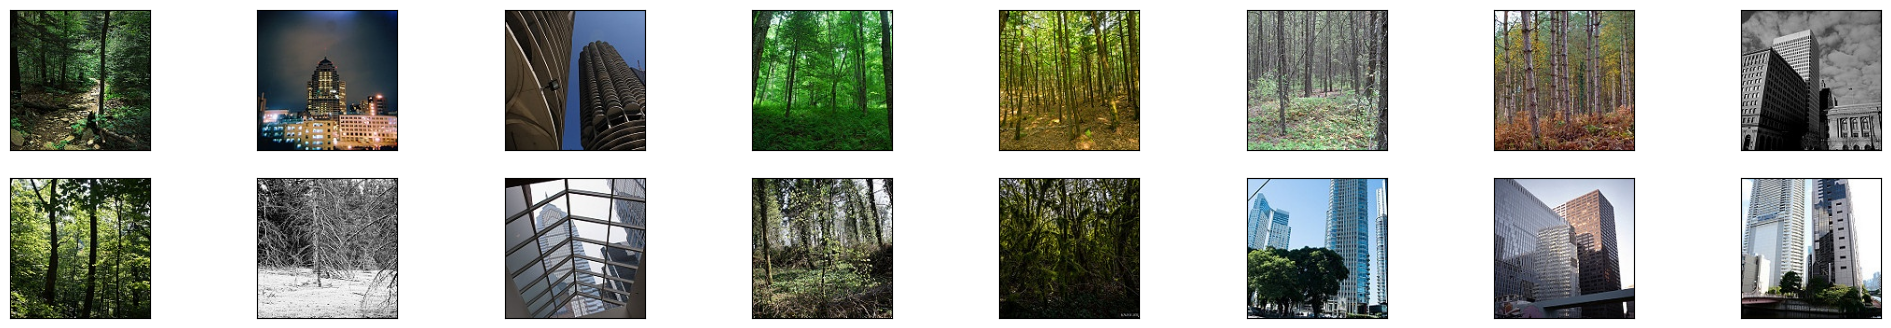

In [12]:
# Define a helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

# Import necessary libraries
import numpy as np

# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()  # convert images to numpy for display

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 16 images
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16 // 2, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])

# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 40px; font-weight: bold;">Model architecture</span>

In [ ]:
# Creating the model
# Formula : ((pixel_size - kernel_size + 2 * padding) / step_size) + 1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Choosing 3 input channels because we have colored images as input
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=20,padding=2)
        self.conv2 = nn.Conv2d(64,128,kernel_size=13,stride=2,padding=2)
        self.pool = nn.MaxPool2d(4,4)
        self.fc1 = nn.Linear(128*16*16,256)
        self.fc2 = nn.Linear(256,256)
        # Choosing 6 for the output layer because we have 6 unique labels
        self.out = nn.Linear(256,6)
        self.drop_out = nn.Dropout()
    def forward(self,X):
        # input image size is [3,150,150]
        X = self.conv1(X)
        # (150-20+2*2)/1+1 -> 135
        # our result will be [64,135,135]
        X = self.conv2(X)
        # (135-13+2*2)/2 + 1 -> 64
        # [128,64,64]
        X = self.pool(X)
        # 64/4 -> 16
        # [128,16,16]
        X = X.reshape(X.size(0), -1)
        # [128*16*16] -> one dimension
        X = self.drop_out(X)
        # Regularization and preventing the co-adaptation of neurons
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        out = self.out(X)
        return X

In [ ]:
# Define the model
model = Net()

# Move the model to the GPU (if available)
model = model.to("cuda")

In [ ]:
# Set the number of training epochs and the learning rate
num_epochs = 7
learning_rate = 0.0001

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for classification tasks
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer

# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 40px; font-weight: bold;">Training the model</span>

In [ ]:
# Training the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Perform Backpropagation and Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/7], Step [100/358], Loss: 0.5765, Accuracy: 87.50%
Epoch [1/7], Step [200/358], Loss: 1.0120, Accuracy: 68.75%
Epoch [1/7], Step [300/358], Loss: 0.3652, Accuracy: 93.75%
Epoch [2/7], Step [100/358], Loss: 1.0147, Accuracy: 56.25%
Epoch [2/7], Step [200/358], Loss: 0.6315, Accuracy: 87.50%
Epoch [2/7], Step [300/358], Loss: 0.6418, Accuracy: 87.50%
Epoch [3/7], Step [100/358], Loss: 0.3938, Accuracy: 87.50%
Epoch [3/7], Step [200/358], Loss: 0.1391, Accuracy: 93.75%
Epoch [3/7], Step [300/358], Loss: 0.1823, Accuracy: 93.75%
Epoch [4/7], Step [100/358], Loss: 0.1119, Accuracy: 100.00%
Epoch [4/7], Step [200/358], Loss: 0.6174, Accuracy: 81.25%
Epoch [4/7], Step [300/358], Loss: 0.5882, Accuracy: 81.25%
Epoch [5/7], Step [100/358], Loss: 0.4717, Accuracy: 87.50%
Epoch [5/7], Step [200/358], Loss: 0.2013, Accuracy: 87.50%
Epoch [5/7], Step [300/358], Loss: 0.6634, Accuracy: 81.25%
Epoch [6/7], Step [100/358], Loss: 0.0941, Accuracy: 100.00%
Epoch [6/7], Step [200/358], Loss: 0.1

# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 40px; font-weight: bold;">Testing the model</span>

In [ ]:
# Testing the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 71.54750244857982 %


In [ ]:
# Saving the model
torch.save(model.state_dict(), 'drive/MyDrive/model.pth')

In [ ]:
# loading the model
model = Net()
model = model.to("cuda")
model.load_state_dict(torch.load('drive/MyDrive/model.pth'))

<All keys matched successfully>

# <span style="color:#d64161; font-family: Trebuchet MS; font-size: 40px; font-weight: bold;">Making Predictions</span>

In [ ]:
# Making predictions for the unlabeled data
pred_loader = DataLoader(prediction_data,shuffle=True)
model.eval()
results = []
image_list = []

with torch.no_grad():
    for images, labels in pred_loader:
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        results.append(predicted)
        image_list.append(images)

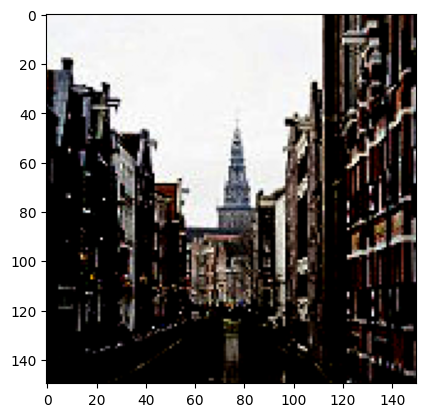

In [ ]:
# The 6th image looks like a building
img_np = image_list[5].cpu().numpy().transpose((2, 3, 1, 0))
plt.imshow(img_np.squeeze())
plt.show()

In [ ]:
# We have predicted building, because '0' corresponds to 'building'
results[5]

tensor([0], device='cuda:0')